In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import json
import random
sys.path.append(os.path.dirname(os.path.abspath('.')))

np.random.seed(42)
random.seed(42)

In [2]:
test_data = pd.read_csv('../data/test/Eat.csv', index_col=False)

income_bins = [-float('inf'), 0, 30000, 60000, 90000, 120000, float('inf')]
income_labels = ['Debt', 'Low', 'Moderate', 'High', 'Very High', 'Ultra High']
age_bins = [-float('inf'), 18, 30, 40, 50, 60, float('inf')]
age_labels = ['Teen', 'Young Adult', 'Adult',
              'Middle Age', 'Senior', 'Elderly']

test_data['income_group'] = pd.cut(
    test_data['individual_income'], bins=income_bins, labels=income_labels)
test_data['age_group'] = pd.cut(
    test_data['age'], bins=age_bins, labels=age_labels)
test_data['income_group'] = pd.cut(
    test_data['individual_income'], bins=income_bins, labels=income_labels)
test_data['age_group'] = pd.cut(
    test_data['age'], bins=age_bins, labels=age_labels)
test_data['target_mode'] = test_data['mode']
test_data.head(2)

,person_id,travel_purpose,target_amenity,mode,distance_miles,duration_minutes,age,individual_income,household_size,family_structure,vehicles,cypher,income_group,age_group,target_mode
0,5.570035e+18,Eat,F&B Eatery/Drinking Places,Walking,0.0,0.0,29,53672,3_person,family_single,1,\n MATCH (p:Person)\n WHERE (p.a...,Moderate,Young Adult,Walking
1,7.600486e+18,Eat,F&B Eatery/Snack and Nonalcoholic Beverage Bars,Walking,0.0,0.0,26,0,3_person,nonfamily_single,0,\n MATCH (p:Person)\n WHERE (p.a...,Debt,Young Adult,Walking


In [4]:
mode_num = 3
amenity_num = 5
num_samples = 0

mode_mapping = {
    'Car': 0,
    'Walking': 1,
    'Public_transport': 2,
    'Public transport': 2,
    'Driving own car': 0,
}
amenity_mapping = {
    'F&B Eatery/Limited-Service Restaurants': 0,
    'F&B Eatery/Snack and Nonalcoholic Beverage Bars': 1,
    'F&B Eatery/Full-Service Restaurants': 2,
    'F&B Eatery/Drinking Places': 3,
    'F&B Eatery/Special Food Services': 4,
    'F&amp;B Eatery/Full-Service Restaurants': 2,
    'F&amp;B Eatery/Snack and Nonalcoholic Beverage Bars': 1
}

reversed_mode_mapping = {
    0: 'Car',
    1: 'Walking',
    2: 'Public_transport',
}
reversed_amenity_mapping = {
    0: 'F&B Eatery/Limited-Service Restaurants',
    1: 'F&B Eatery/Snack and Nonalcoholic Beverage Bars',
    2: 'F&B Eatery/Full-Service Restaurants',
    3: 'F&B Eatery/Drinking Places',
    4: 'F&B Eatery/Special Food Services',
}

In [11]:

log_data = pd.read_csv(f'../data/logs/{num_samples}/Eat.csv', index_col=False)
log_data = log_data.drop(
    columns=['mode_recommendation', 'amenity_recommendation', 'cypher'])


def normalize(x):
    total = np.sum(x)
    norm_x = np.divide(x, total, out=np.zeros_like(x), where=total != 0)
    return norm_x


def get_mode_probs(row):
    try:
        mode_llm_choice = json.loads(row['mode_llm_choice'])
        mode_probs = np.zeros(mode_num)
        for item in mode_llm_choice['final_answer']:
            option = item['choice'].strip()
            if option in mode_mapping:
                index = mode_mapping[option]
                mode_probs[index] = item['weight']
        mode_probs = normalize(mode_probs)
    except Exception as e:
        return None
    return mode_probs


def get_amenity_probs(row):
    try:
        amenity_llm_choice = json.loads(row['amenity_llm_choice'])
        amenity_probs = np.zeros(amenity_num)
        for item in amenity_llm_choice['final_answer']:
            option = item['choice'].strip()
            if option in amenity_mapping:
                index = amenity_mapping[option]
                amenity_probs[index] = item['weight']
        amenity_probs = normalize(amenity_probs)
    except Exception as e:
        return None
    return amenity_probs


def get_mode_choice(row):
    mode_probs = row['mode_probs']
    # mode_choice = np.random.choice(mode_num, p=mode_probs)
    mode_choice = random.choices(range(mode_num), weights=mode_probs, k=1)[0]
    return mode_choice


def get_amenity_choice(row):
    amenity_probs = row['amenity_probs']
    # amenity_choice = np.random.choice(amenity_num, p=amenity_probs)
    amenity_choice = random.choices(
        range(amenity_num), weights=amenity_probs, k=1)[0]
    return amenity_choice


log_data['mode_probs'] = log_data.apply(get_mode_probs, axis=1)
log_data['amenity_probs'] = log_data.apply(get_amenity_probs, axis=1)

log_data['predict_mode_numeric'] = log_data.apply(get_mode_choice, axis=1)
log_data['predict_amenity_numeric'] = log_data.apply(
    get_amenity_choice, axis=1)

# log_data = log_data.dropna()
log_data.head(2)

,person_id,profile,top_k,desire,city,amenity_llm_choice,amenity_final_choice,mode_llm_choice,mode_final_choice,mode_probs,amenity_probs,predict_mode_numeric,predict_amenity_numeric
0,5.570035e+18,"A 29 year old person, living in a family_singl...",0,Eat,Boston,"{ \n ""thought"": ""Based on the profile, this i...",F&B Eatery/Limited-Service Restaurants,"{ \n""thought"": ""Based on the profile, a typica...",Walking,"[0.0, 0.6666666666666667, 0.33333333333333337]","[0.3, 0.2, 0.4, 0.05, 0.05]",2,2
1,7.600486e+18,"A 26 year old person, living in a nonfamily_si...",0,Eat,Boston,"{ \n""thought"": ""Based on the profile, this per...",F&B Eatery/Limited-Service Restaurants,"{ \n ""thought"": ""Based on the profile, a you...",Public_transport,"[0.05, 0.4, 0.55]","[0.65, 0.25, 0.05, 0.03, 0.02]",1,0


In [5]:
pred_data = log_data[['person_id', 'mode_probs',
                      'amenity_probs', 'predict_mode_numeric', 'predict_amenity_numeric']]
true_data = test_data[['person_id', 'income_group',
                       'age_group', 'target_amenity', 'target_mode']]

merged_data = pd.merge(pred_data, true_data, on='person_id')
merged_data['target_amenity_numeric'] = merged_data['target_amenity'].map(
    amenity_mapping)
merged_data['target_amenity'] = merged_data['target_amenity_numeric'].map(
    reversed_amenity_mapping)

merged_data['target_mode_numeric'] = merged_data['target_mode'].map(
    mode_mapping)
merged_data['target_mode'] = merged_data['target_mode_numeric'].map(
    reversed_mode_mapping)

merged_data['predict_mode'] = merged_data['predict_mode_numeric'].map(
    reversed_mode_mapping)
merged_data['predict_amenity'] = merged_data['predict_amenity_numeric'].map(
    reversed_amenity_mapping)

merged_data = merged_data[~merged_data['mode_probs'].apply(
    lambda x: np.isnan(x).any())]
merged_data = merged_data[~merged_data['amenity_probs'].apply(
    lambda x: np.isnan(x).any())]

amenity_probs = np.vstack(merged_data['amenity_probs'])
merged_data = merged_data[amenity_probs.sum(axis=1) == 1]

mode_probs = np.vstack(merged_data['mode_probs'])
merged_data = merged_data[mode_probs.sum(axis=1) == 1]

merged_data = merged_data.dropna()
merged_data.head()

,person_id,mode_probs,amenity_probs,predict_mode_numeric,predict_amenity_numeric,income_group,age_group,target_amenity,target_mode,target_amenity_numeric,target_mode_numeric,predict_mode,predict_amenity
0,5.570035e+18,"[0.26, 0.42, 0.32]","[0.15, 0.35, 0.45, 0.05, 0.0]",1,0,Moderate,Young Adult,F&B Eatery/Drinking Places,Walking,3,1,Walking,F&B Eatery/Limited-Service Restaurants
1,7.600486e+18,"[0.25, 0.4, 0.35]","[0.05, 0.25, 0.65, 0.05, 0.0]",0,2,Debt,Young Adult,F&B Eatery/Snack and Nonalcoholic Beverage Bars,Walking,1,1,Car,F&B Eatery/Full-Service Restaurants
2,8.362513e+18,"[0.52, 0.16, 0.32]","[0.09, 0.21, 0.63, 0.07, 0.0]",0,2,Low,Elderly,F&B Eatery/Full-Service Restaurants,Car,2,0,Car,F&B Eatery/Full-Service Restaurants
3,1.381425e+19,"[0.5, 0.15, 0.35]","[0.26, 0.15, 0.53, 0.05, 0.01]",0,3,Moderate,Young Adult,F&B Eatery/Limited-Service Restaurants,Public_transport,0,2,Car,F&B Eatery/Drinking Places
4,1.590730e+19,"[0.09, 0.52, 0.39]","[0.12, 0.24, 0.58, 0.06, 0.0]",2,1,Moderate,Young Adult,F&B Eatery/Drinking Places,Walking,3,1,Public_transport,F&B Eatery/Snack and Nonalcoholic Beverage Bars


In [6]:

def get_error(x, y_true, y_pred):

    contingency_table = pd.crosstab(y_true, x)
    percentage_table = contingency_table.div(
        contingency_table.sum(axis=0), axis=1) * 100

    predict_contingency_table = pd.crosstab(
        y_pred, x)
    predict_percentage_table = predict_contingency_table.div(
        contingency_table.sum(axis=0), axis=1) * 100

    error_table = (predict_percentage_table-percentage_table)/100

    average_error = error_table.abs().mean()
    total_average_error = average_error.mean()
    return total_average_error, error_table

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss


def evaluate_with_cv(data, choice_type, cv=5):
    losses = []
    age_errors = []
    income_errors = []

    y_true = np.array(data[f'target_{choice_type}'])
    y_pred = np.array(data[f'predict_{choice_type}'])

    y_true_numeric = np.array(data[f'target_{choice_type}_numeric'])
    y_pred_probs = np.vstack(data[f'{choice_type}_probs'])

    # split X_test and y_test into cv folds
    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y_true_numeric.reshape(-1, 1))
    test_index = np.arange(len(y_true))

    # kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    # for _, test_index in kf.split(y_true):

    # log loss
    y_fold_onehot = y_onehot[test_index]
    y_fold_prob = y_pred_probs[test_index]
    loss = log_loss(y_fold_onehot, y_fold_prob)
    losses.append(loss)
    # error
    for x_label in ['age_group', 'income_group']:
        x_fold = np.array(data[x_label])[test_index]
        y_pred_fold = y_pred[test_index]
        y_true_fold = y_true[test_index]
        error, _ = get_error(x_fold, y_true_fold, y_pred_fold)
        if x_label == 'age_group':
            age_errors.append(error)
        else:
            income_errors.append(error)
    loss = np.mean(losses)
    age_error = np.mean(age_errors)
    income_error = np.mean(income_errors)
    return loss, age_error, income_error

In [8]:
def evaluate(num_sample, choice_type='mode'):
    log_data = pd.read_csv(
        f'../data/logs/{num_sample}/Eat.csv', index_col=False)
    log_data['mode_probs'] = log_data.apply(get_mode_probs, axis=1)
    log_data['amenity_probs'] = log_data.apply(get_amenity_probs, axis=1)
    log_data['predict_mode_numeric'] = log_data.apply(get_mode_choice, axis=1)
    log_data['predict_amenity_numeric'] = log_data.apply(
        get_amenity_choice, axis=1)
    log_data = log_data.dropna()

    pred_data = log_data[['person_id', 'mode_probs',
                          'amenity_probs', 'predict_mode_numeric', 'predict_amenity_numeric']]
    true_data = test_data[['person_id', 'income_group',
                           'age_group', 'target_amenity', 'target_mode']]

    merged_data = pd.merge(pred_data, true_data, on='person_id')

    merged_data['target_amenity_numeric'] = merged_data['target_amenity'].map(
        amenity_mapping)
    merged_data['target_amenity'] = merged_data['target_amenity_numeric'].map(
        reversed_amenity_mapping)

    merged_data['target_mode_numeric'] = merged_data['target_mode'].map(
        mode_mapping)
    merged_data['target_mode'] = merged_data['target_mode_numeric'].map(
        reversed_mode_mapping)

    merged_data['predict_mode'] = merged_data['predict_mode_numeric'].map(
        reversed_mode_mapping)
    merged_data['predict_amenity'] = merged_data['predict_amenity_numeric'].map(
        reversed_amenity_mapping)

    # merged_data = merged_data[~merged_data['mode_probs'].apply(
    #     lambda x: np.isnan(x).any())]
    # merged_data = merged_data[~merged_data['amenity_probs'].apply(
    #     lambda x: np.isnan(x).any())]

    amenity_probs = np.vstack(merged_data['amenity_probs'])
    merged_data = merged_data[amenity_probs.sum(axis=1) == 1]

    mode_probs = np.vstack(merged_data['mode_probs'])
    merged_data = merged_data[mode_probs.sum(axis=1) == 1]

    merged_data = merged_data.dropna()

    results = {}
    results['num_sample'] = num_sample

    loss, age_error, income_error = evaluate_with_cv(merged_data, choice_type)

    results[f'loss'] = loss
    results[f'age_error'] = age_error
    results[f'income_error'] = income_error

    return results

In [9]:
results = evaluate(5000, 'mode')
print(results)

{'num_sample': 5000, 'loss': 1.092815741712418, 'age_error': 0.06635454243654787, 'income_error': 0.04722748903491339}


In [10]:
plot_data = pd.DataFrame(
    columns=['num_sample', 'loss', 'age_error', 'income_error'])
x_label = 'age_group'
choice_type = 'amenity'

for num_sample in range(1, 11):
    num_sample = num_sample * 2000
    loss = evaluate(num_sample, choice_type)
    plot_data.loc[len(plot_data)] = loss
plot_data.head()

,num_sample,loss,age_error,income_error
0,2000,1.483518,0.055663,0.056669
1,4000,1.646632,0.050614,0.052669
2,6000,1.617333,0.063008,0.033632
3,8000,1.569737,0.043401,0.043633
4,10000,1.677345,0.041217,0.034791


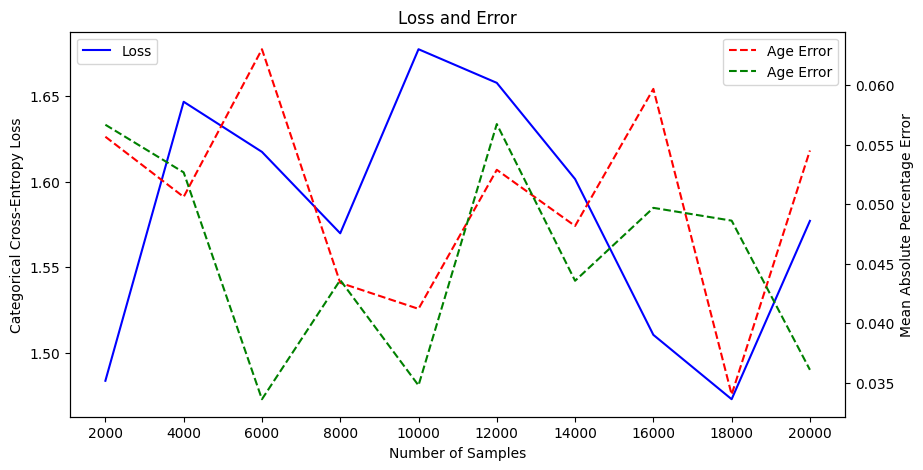

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot accuracy on the primary y-axis
sns.lineplot(data=plot_data, x='num_sample',
             y='loss', ax=ax1, color='b', label='Loss')


ax1.set_title('Loss and Error')
ax1.set_xlabel('Number of Samples')
ax1.set_ylabel('Categorical Cross-Entropy Loss')
ax1.legend(loc='upper left')

# Create a second y-axis for the errors
ax2 = ax1.twinx()
sns.lineplot(data=plot_data, x='num_sample', y='age_error',
             ax=ax2, color='r', linestyle='--', label='Age Error')
sns.lineplot(data=plot_data, x='num_sample', y='income_error',
             ax=ax2, color='g', linestyle='--', label='Age Error')
ax2.set_ylabel('Mean Absolute Percentage Error')
ax2.legend(loc='upper right')

# Optional: Set xticks if needed
ax1.set_xticks(plot_data['num_sample'])

plt.show()